In [1]:
from coffea.util import load
import numpy as np
import pandas as pd
import glob, os, json, argparse
years = ['2016preVFP', '2016postVFP', '2018','2017']
var_dict = [{}, {}, {}]
for year in years:
  print(f'Processing {year}')
  result = load(f"../results/{year}/makeDF/output_WJet2.coffea")
  if isinstance(result,tuple):
      result = result[0]
  for varName in result:
    for i in range(2,3):
      if f'{i}jets' in varName:
        if varName.replace(f'_{i}jets','') in var_dict[i]:
          var_dict[i][varName.replace(f'_{i}jets','')] = np.append(var_dict[i][varName.replace(f'_{i}jets','')],result[varName].value)
        else:
          var_dict[i][varName.replace(f'_{i}jets','')] = result[varName].value
df = pd.DataFrame(var_dict[i])

Processing 2016preVFP
Processing 2016postVFP
Processing 2018
Processing 2017


In [2]:
data_clean = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
data_cuts = data_clean[(data_clean['weight']!=0)&(data_clean['opp_charge']==1)&(data_clean['e_m_Mass']>115)&(data_clean['e_m_Mass']<135)&((data_clean['label']==1)|(data_clean['label']==0))]
data_vbf = data_cuts[data_cuts.isVBFcat==1]

In [9]:
feature_names = ['Zeppenfeld_DeltaEta', 'met', 'DeltaEta_e_m', 'empt', 'j1pt', 'DeltaEta_j1_j2', 'j1_j2_mass', 'Ht_had', 'Rpt', 'j2pt', 'pt_cen_Deltapt']

In [15]:
feature_names_tex = ['Zeppenfeld', '$E^{miss}_{T}$', '$\Delta \eta[e, \mu]$', '$p_{T}^{e\mu}$', '$p_{T}^{j_{1}}$', '$\Delta \eta[j_{1}, j_{2}]$', '$m_{j_{1}j_{2}}$ [GeV]', '$H_{T}$', '$R_{p_{T}}$', '$p_{T}^{j_{2}}$', '$p_{T}$-centrality']
feature_names_tex_dict = {feature_name:feature_name_tex for feature_name, feature_name_tex in zip(feature_names, feature_names_tex)}

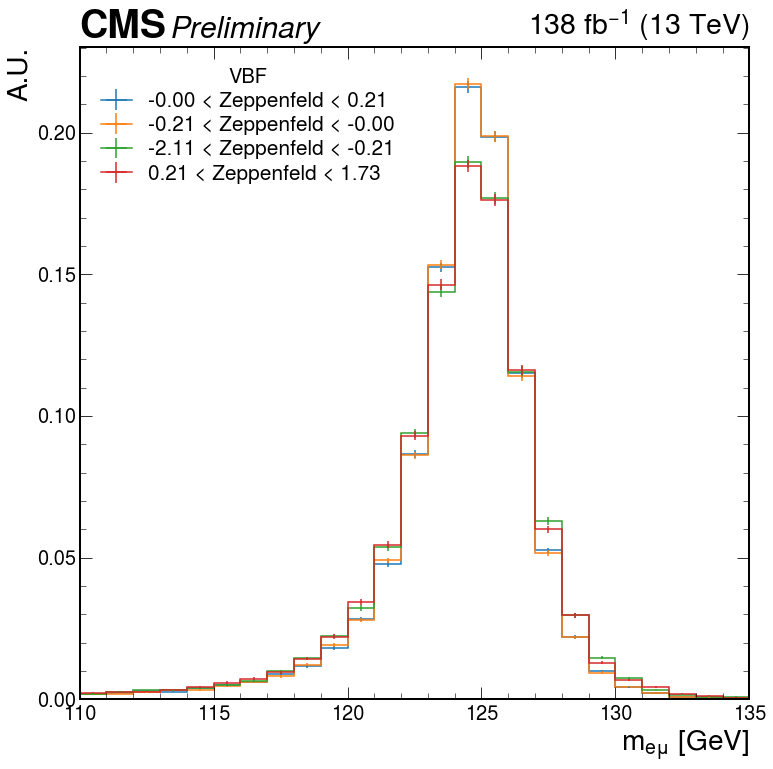

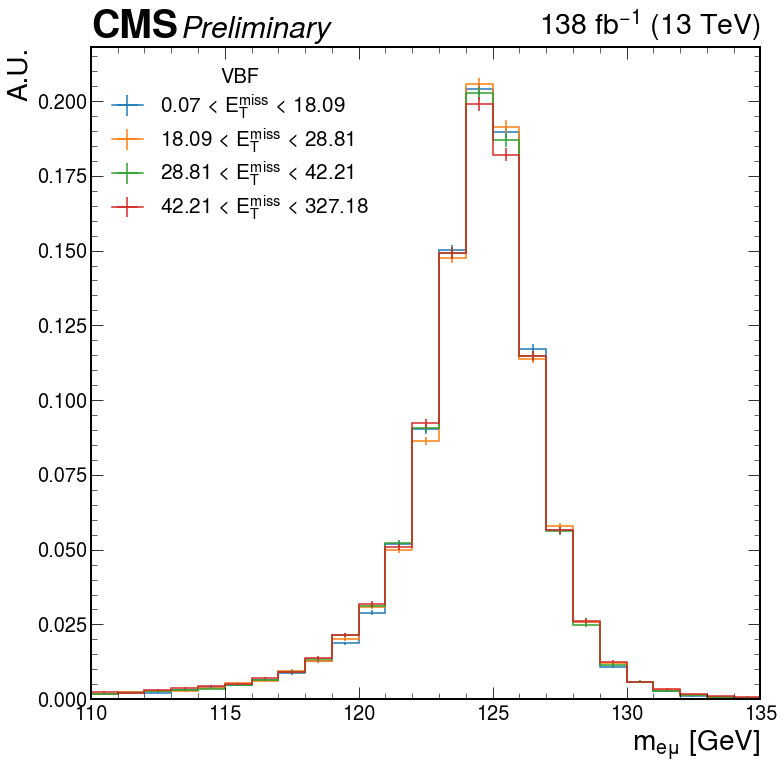

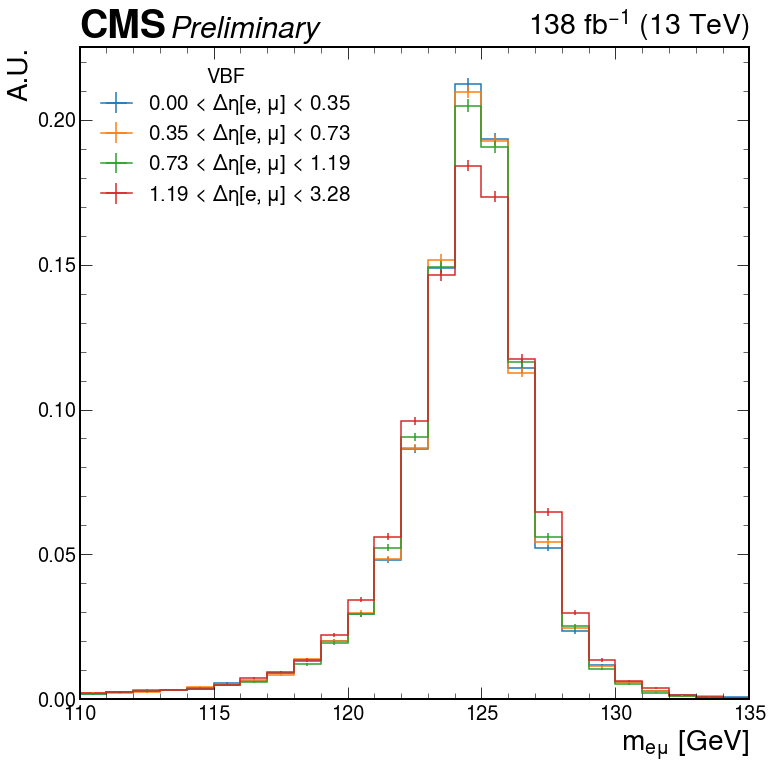

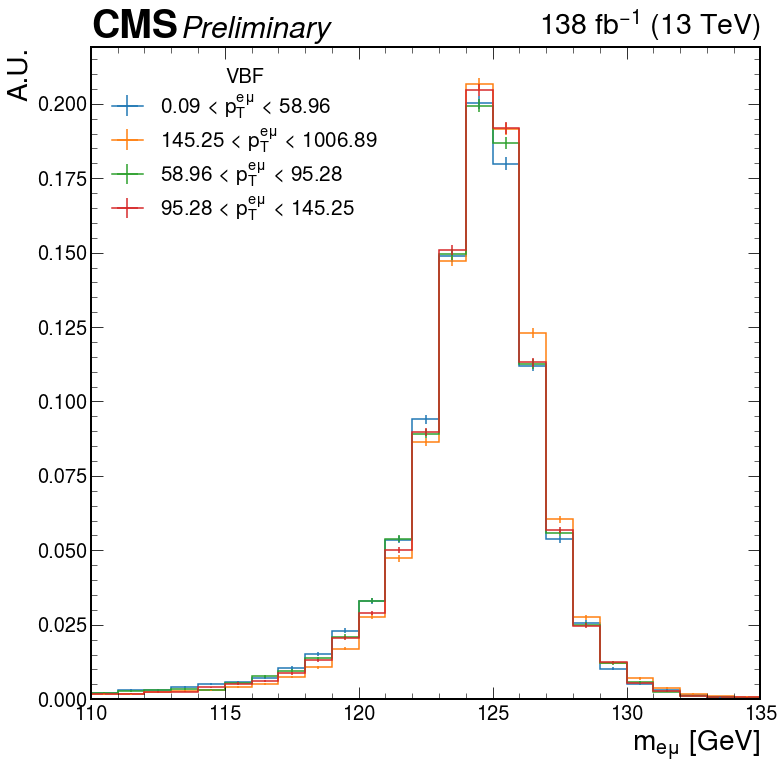

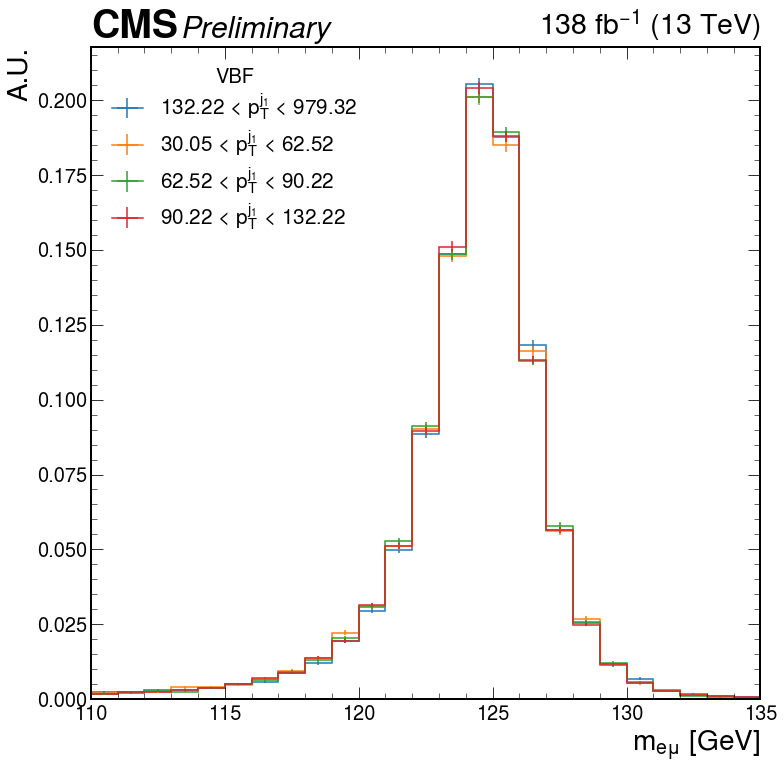

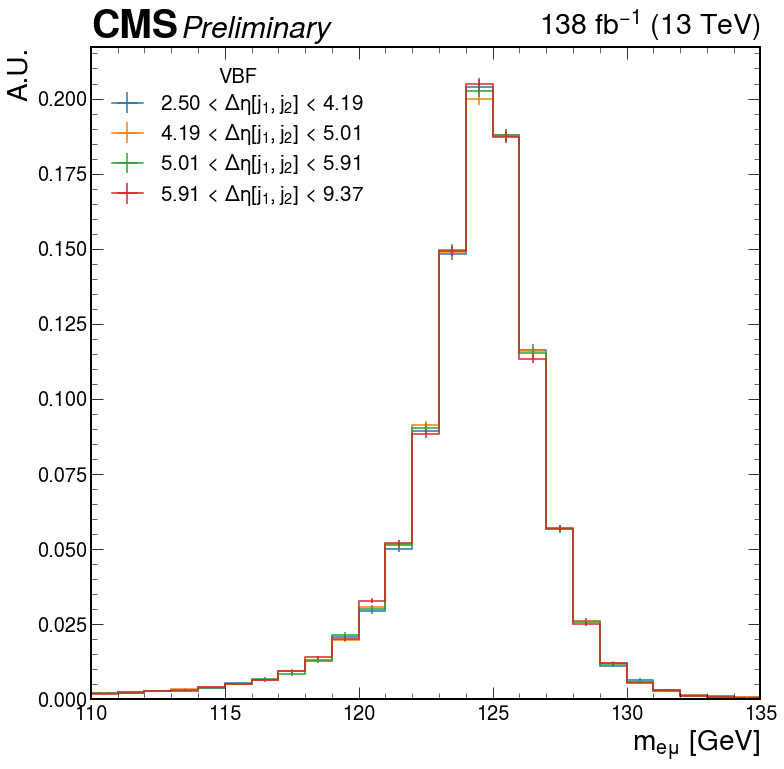

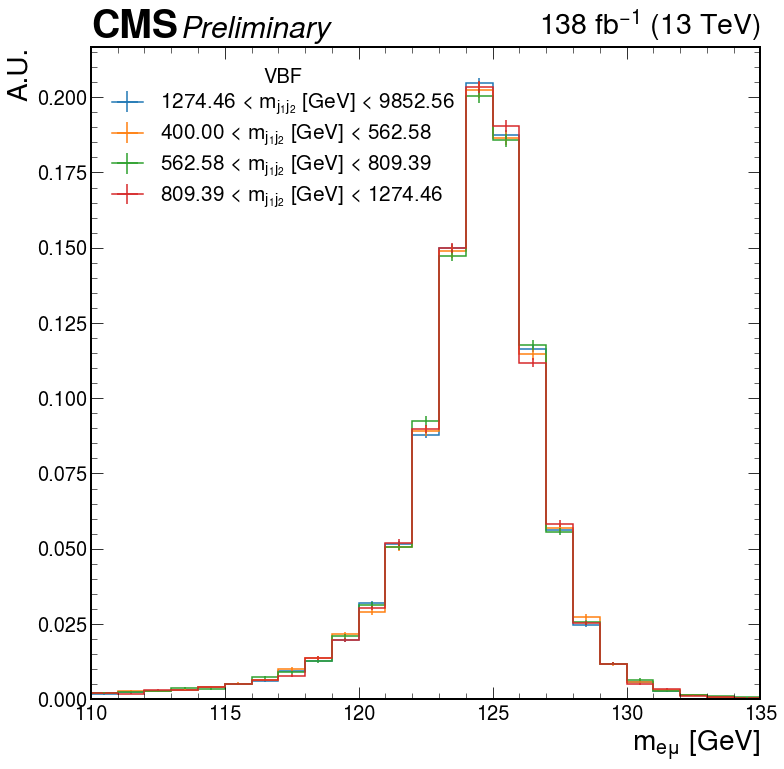

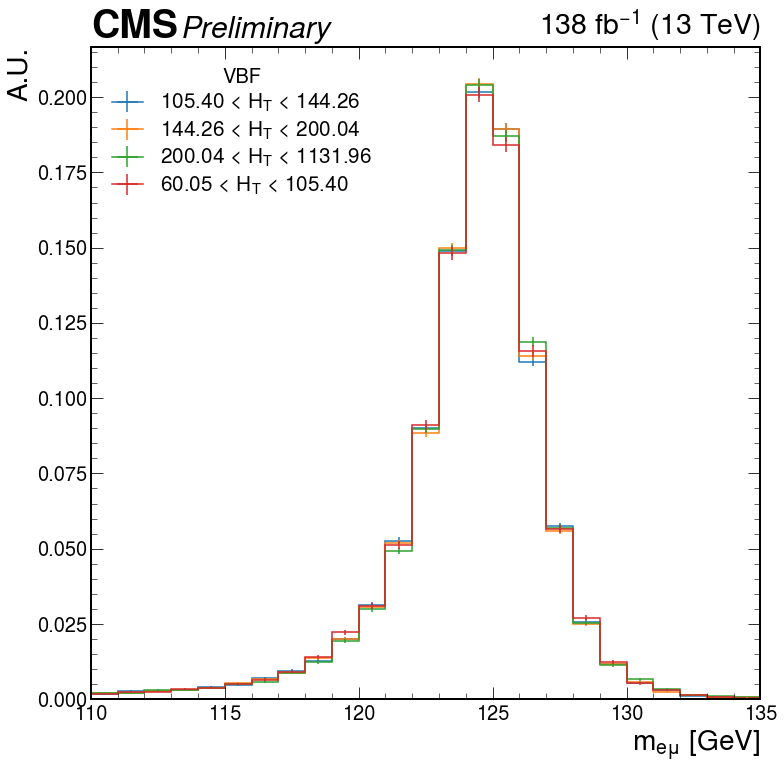

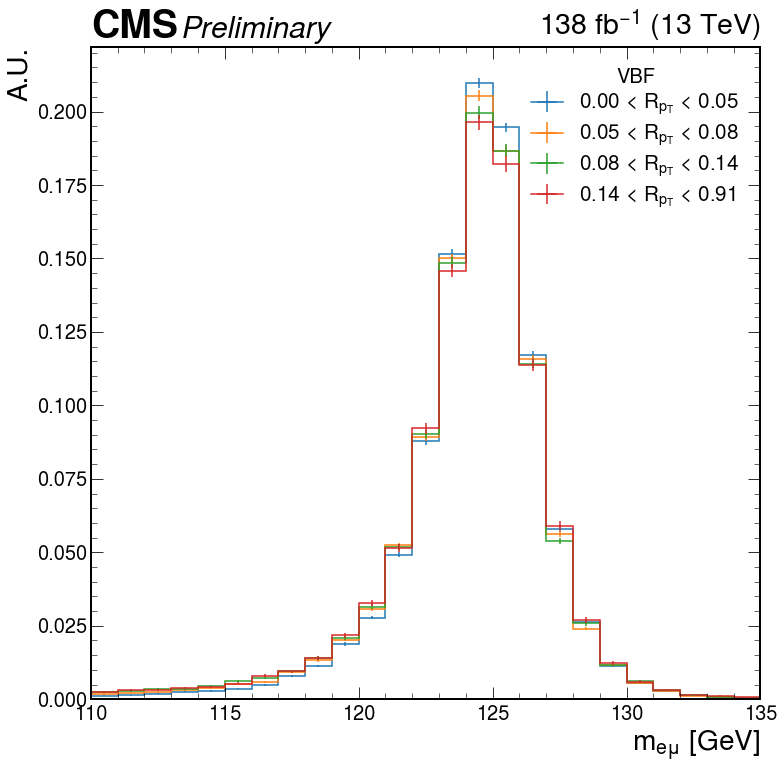

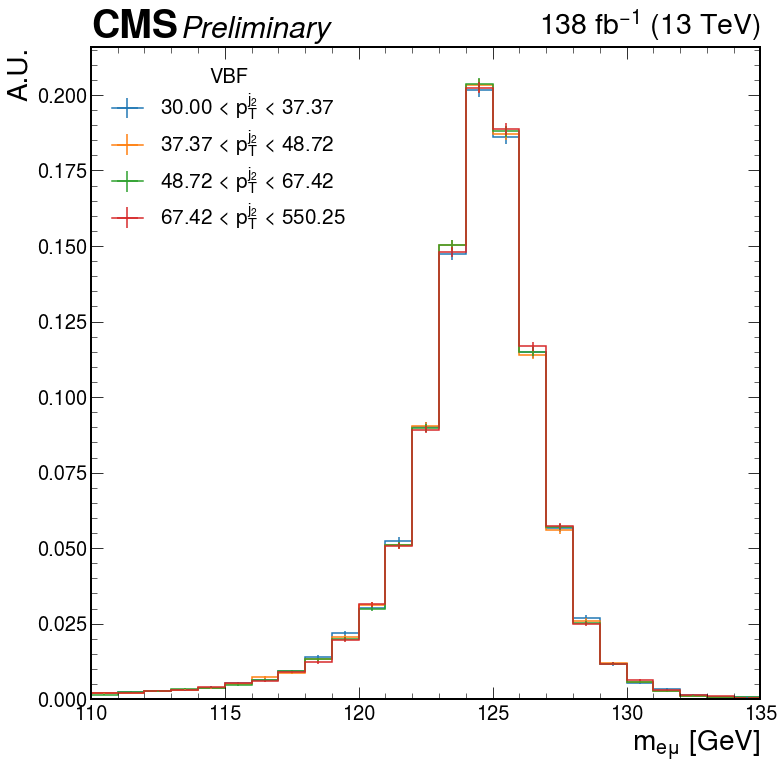

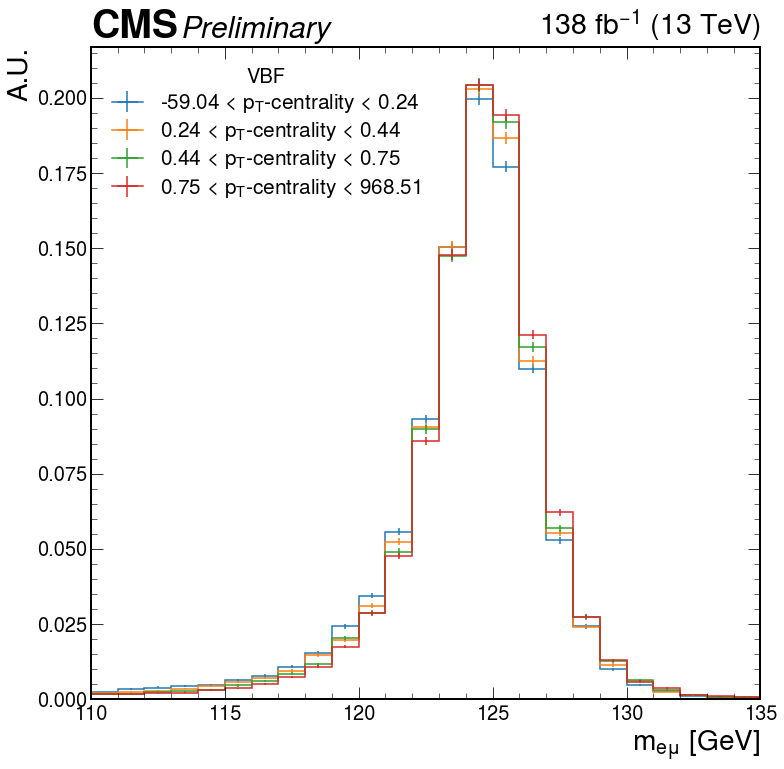

In [19]:
from coffea import hist
import mplhep
import matplotlib.pyplot as plt
%matplotlib inline

#Get the signal
data_bkg = data_clean[(data_clean['label']==1)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==1)]

#Get 20% quantiles of the background
from statsmodels.stats.weightstats import DescrStatsW

for feature_name in feature_names:
    wq = DescrStatsW(data=data_bkg[feature_name], weights=data_bkg['weight'])
    h_quan = hist.Hist('A.U.', hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 25, 110, 135), hist.Cat("sample", "sample"))
    quantiles = wq.quantile(probs=np.array([0, 0.25, 0.50, 0.75, 1]), return_pandas=False)
    for i in range(len(quantiles)-1):
        #Fill in sliced invariant mass according to MVA quantiles
        quant25 = data_bkg[(data_bkg[feature_name]<quantiles[i+1])&(data_bkg[feature_name]>=quantiles[i])]
        label = f'{quantiles[i]:.2f} < {feature_names_tex_dict[feature_name]} < {quantiles[i+1]:.2f}'
        h_quan.fill(e_m_Mass=quant25['e_m_Mass'].to_numpy(), sample=label, weight=quant25['weight'].to_numpy())
        #scales[label] = 1/np.sum(quant25['weight'].to_numpy())

    #h_quan.scale(scales, axis='sample')

    plt.style.use(mplhep.style.CMS)
    plt.rcParams.update({
        'font.size': 30,
        'axes.titlesize': 24,
        'axes.labelsize': 28,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.title_fontsize': 20
    })

    fig = plt.figure(
            figsize=(12,12),
          )

    ax = hist.plot1d(h_quan, density=True)
    #ax.set_ylim(0, 0.05)
    leg = ax.legend(fontsize='x-small', labelspacing=0.25, title="VBF")

    lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
    #fig.savefig(f'plots/BDTValid/{catcatcat}_bkg.png')